In [1]:
import sys
sys.path.append('..')
from src.pomdp import *

import numpy as np

## 2-state 2-action symmetric problem

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,0]

array([0.7, 0.3])

In [5]:
REWARD_PROBS = [0.2, 0.6]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p,:] = REWARD_PROBS[s_p]
        
reward_table

array([[[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]],


       [[[0.2, 0.2],
         [0.6, 0.6]],

        [[0.2, 0.2],
         [0.6, 0.6]]]])

In [6]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = Model(states=states,
              actions=actions,
              observations=observations,
              transitions=transition_table,
              rewards=reward_table,
              observation_table=observation_table,
              rewards_are_probabilistic=True)

[01/21/2024, 12:04:37] Instantiation of MDP Model:
[01/21/2024, 12:04:37] - 2 states
[01/21/2024, 12:04:37] - 2 actions
[01/21/2024, 12:04:37] - Starting generation of transitions table
[01/21/2024, 12:04:37]     > Done in 0.000s
[01/21/2024, 12:04:37] - Generation of state grid
[01/21/2024, 12:04:37] - Generating start probabilities table
[01/21/2024, 12:04:37] - Starting computation of reachable states from transition data
[01/21/2024, 12:04:37]     > Done in 0.000s
[01/21/2024, 12:04:37] - At most 2 reachable states per state-action pair
[01/21/2024, 12:04:37] - Starting computation of reachable state probabilities from transition data
[01/21/2024, 12:04:37]     > Done in 0.000s

[01/21/2024, 12:04:37] POMDP particular parameters:
[01/21/2024, 12:04:37] - 2 observations
[01/21/2024, 12:04:37] - Starting of transitional observations for reachable states table
[01/21/2024, 12:04:37]     > Done in 0.000s
[01/21/2024, 12:04:37] - Starting generation of expected rewards table
[01/21/2024

## Run 100 iterations of backup for 100 different belief sets

In [7]:
c = 100

belief_sets = [BeliefSet(model, [Belief(model, np.array([i/c, 1.0 - (i/c)])), Belief(model, np.array([1.0 - (i/c), i/c]))]) for i in range(int((c/2)+1))]

In [8]:
solver = PBVI_Solver(gamma=0.99)

In [9]:
print(belief_sets[0])

In [10]:
value_functions = []

init_value_function = ValueFunction(model, model.expected_rewards_table, model.actions)
eps = 0.0001
max_allowed_change = eps * (0.99 / (1-0.99))

for belief_set in belief_sets:
    vf = copy.deepcopy(init_value_function)
    old_max_val_per_belief = None
    # belief_set = [belief_set[0]]

    it_count = 1000
    for iter in range(1000):
        vf = solver.backup(model, belief_set, vf)

        max_val_per_belief = np.max(np.matmul(belief_set.belief_array, vf.alpha_vector_array.T), axis=1)
        if old_max_val_per_belief is not None:
            max_change = np.max(np.abs(max_val_per_belief - old_max_val_per_belief))
            if max_change < max_allowed_change:
                # print('early convergence')
                it_count = iter
                break
        old_max_val_per_belief = max_val_per_belief

    print(f'belief s0 {belief_set.belief_array[0]} - max {np.max(vf.alpha_vector_array)} - min {np.min(vf.alpha_vector_array)} (iter count {it_count})')

    value_functions.append(vf)

belief s0 [0. 1.] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.01 0.99] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.02 0.98] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.03 0.97] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.04 0.96] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.05 0.95] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.06 0.94] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.07 0.93] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.08 0.92] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.09 0.91] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.1 0.9] - max 39.324873290949945 - min 38.73374028602384 (iter count 368)
belief s0 [0.11 0.89] - max 39.3248732

In [11]:
all_vectors = []
for avs in value_functions[:-1]:
    all_vectors += avs.alpha_vector_list

vect_array = np.array([av.values for av in all_vectors])

<Figure size 800x500 with 0 Axes>

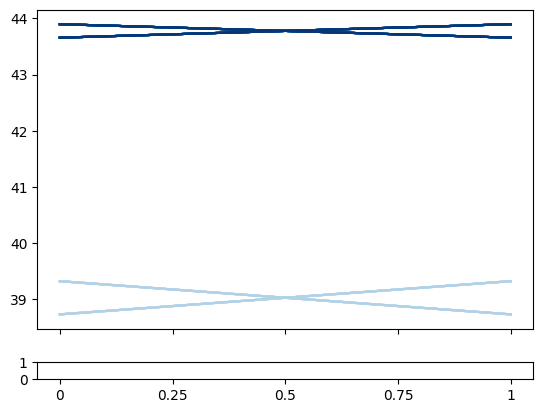

In [12]:
x = np.linspace(0, 1, 100)

plt.figure(figsize=(8,5))
grid_spec = {'height_ratios': ([1] if belief_set is None else [19,1])}
_, ax = plt.subplots(2,1,sharex=True,gridspec_kw=grid_spec)

# Vector plotting
m = vect_array[:,1] - vect_array[:,0] # type: ignore
m = m.reshape(m.shape[0],1)

x = x.reshape((1,x.shape[0])).repeat(m.shape[0],axis=0)
y = (m*x) + vect_array[:,0].reshape(m.shape[0],1)

ax1 = ax[0]
colors = plt.get_cmap('Blues') # type: ignore

for i in range(0, vect_array.shape[0]):
    ax1.plot(x[i,:], y[i,:], c=colors(int((int(i/2)/50)*255))) # type: ignore

# X-axis setting
ticks = [0,0.25,0.5,0.75,1]
x_ticks = [str(t) for t in ticks]

ax1.set_xticks(ticks, x_ticks) # type: ignore
plt.show()

In [13]:
# sh = SolverHistory(
#     model,
#     initial_value_function=value_functions[0],
#     initial_belief_set=belief_sets[0],
#     expand_function='No expand',
#     gamma=0.99,
#     eps=eps
#     )

# for vf, bs in zip(value_functions[1:], belief_sets[1:]):
#     sh.add(vf, bs)

In [14]:
# sh.save_history_video(custom_name='obs_exp_belief', fps=2)

## MDP problem

In [15]:
from src.mdp import VI_Solver

In [16]:
vi_solver = VI_Solver()

In [17]:
vf, solver_history = vi_solver.solve(model)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Figure size 700x500 with 0 Axes>

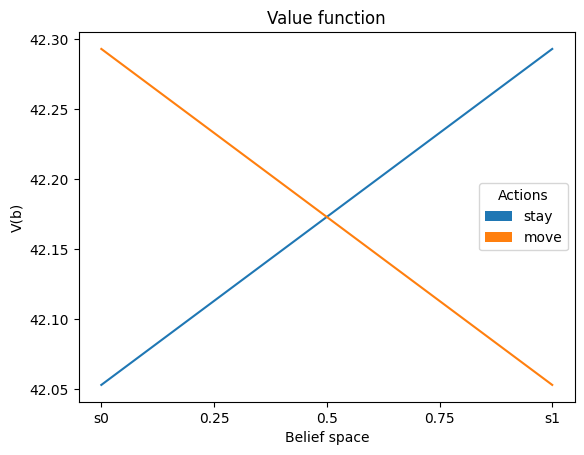

In [18]:
vf.plot()

We can see there is a different convergence of the value depending on the belief set used, it converges to two different value function depending on a belief threshold.

Between [0.00 1.00] and [0.16 0.84] beliefs, we can see it converges to a value function that is lower than the value function for beliefs between [0.17 0.83] and [0.50 0.50] where the value function is higher. This could signify that 0.84 would be the certainty threshold beyond which the agent is sure about his action and can aim to maximize his gains. Under this, in uncertainty, the value function needs to reach higher to converge, also shown by the amount of iterations required to converged, 596 vs 607

## Equal belief set, different observation probs

In [19]:
all_beliefs = []

for beliefs in belief_sets:
    all_beliefs.extend(beliefs.belief_list)

all_beliefs = BeliefSet(model, all_beliefs)

In [20]:
obs_rnds = np.linspace(0.5,1.0,11)

obs_tables = []
for i in range(obs_rnds.shape[0]):
    observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
    obs_rnd = obs_rnds[i]
    for s_p in range(STATE_COUNT):
        for a in range(ACTION_COUNT):
            for o in range(STATE_COUNT):
                observation_table[s_p, a, o] = obs_rnd if s_p == o else (1.0 - obs_rnd) / (STATE_COUNT - 1)

    obs_tables.append(observation_table)

In [21]:
obs_models = [
    Model(states=states,
                  actions=actions,
                  observations=observations,
                  transitions=transition_table,
                  rewards=reward_table,
                  observation_table=obs_table,
                  rewards_are_probabilistic=True)
    for obs_table in obs_tables
]

[01/21/2024, 12:05:33] Instantiation of MDP Model:
[01/21/2024, 12:05:33] - 2 states
[01/21/2024, 12:05:33] - 2 actions
[01/21/2024, 12:05:33] - Starting generation of transitions table
[01/21/2024, 12:05:33]     > Done in 0.000s
[01/21/2024, 12:05:33] - Generation of state grid
[01/21/2024, 12:05:33] - Generating start probabilities table
[01/21/2024, 12:05:33] - Starting computation of reachable states from transition data
[01/21/2024, 12:05:33]     > Done in 0.000s
[01/21/2024, 12:05:33] - At most 2 reachable states per state-action pair
[01/21/2024, 12:05:33] - Starting computation of reachable state probabilities from transition data
[01/21/2024, 12:05:33]     > Done in 0.000s

[01/21/2024, 12:05:33] POMDP particular parameters:
[01/21/2024, 12:05:33] - 2 observations
[01/21/2024, 12:05:33] - Starting of transitional observations for reachable states table
[01/21/2024, 12:05:33]     > Done in 0.000s
[01/21/2024, 12:05:33] - Starting generation of expected rewards table
[01/21/2024

In [22]:
value_functions = []

init_value_function = ValueFunction(model, model.expected_rewards_table, model.actions)
eps = 0.001
max_allowed_change = eps * (0.99 / (1-0.99))

for i, model in enumerate(obs_models):
    vf = copy.deepcopy(init_value_function)
    old_max_val_per_belief = None
    
    it_count = 1000

    for iter in range(1000):
        vf = solver.backup(model, all_beliefs, vf)

        max_val_per_belief = np.max(np.matmul(all_beliefs.belief_array, vf.alpha_vector_array.T), axis=1)
        if old_max_val_per_belief is not None:
            max_change = np.max(np.abs(max_val_per_belief - old_max_val_per_belief))
            if max_change < max_allowed_change:
                it_count = iter
                # print('early convergence')
                break
        old_max_val_per_belief = max_val_per_belief

    print(f'obs rnd {obs_rnds[i]:.2f} - max {np.max(vf.alpha_vector_array)} - min {np.min(vf.alpha_vector_array)} (iter count {it_count})')


    value_functions.append(vf)

obs rnd 0.50 - max 30.500954541065976 - min 29.90982153613987 (iter count 138)
obs rnd 0.55 - max 31.766573744842102 - min 31.22017024711473 (iter count 142)
obs rnd 0.60 - max 32.86006102477026 - min 32.35356584496229 (iter count 144)
obs rnd 0.65 - max 34.04178705489303 - min 33.60528661391779 (iter count 147)
obs rnd 0.70 - max 35.201002743439766 - min 34.77750362678456 (iter count 150)
obs rnd 0.75 - max 36.287085711465444 - min 35.87982719146544 (iter count 152)
obs rnd 0.80 - max 37.50556424805844 - min 37.26556424805844 (iter count 155)
obs rnd 0.85 - max 38.644678686967524 - min 38.40467868696752 (iter count 157)
obs rnd 0.90 - max 39.887940904458254 - min 39.64794090445825 (iter count 160)
obs rnd 0.95 - max 41.038826104986704 - min 40.7988261049867 (iter count 162)
obs rnd 1.00 - max 42.29309361078366 - min 42.053093610783655 (iter count 165)


In [23]:
value_functions[-5].alpha_vector_list

Text(0.5, 0, 'Belief Space (b)')

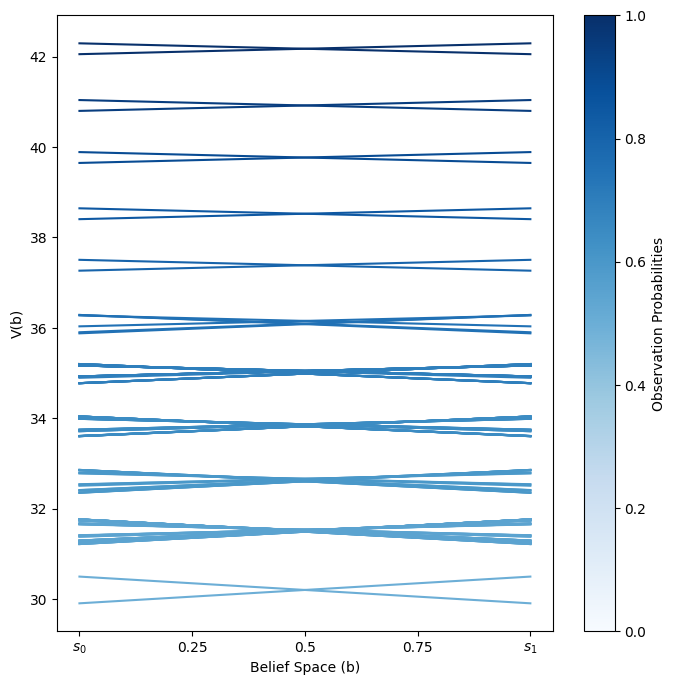

In [28]:
all_vectors = []
rnd_list = []
for i, avs in enumerate(value_functions):
    all_vectors += [av.values for av in avs.alpha_vector_list]
    rnd_list += [obs_rnds[i] * 255] * len(avs)

all_vectors = np.array(all_vectors)

x = np.linspace(0, 1, 100)

# plt.figure(figsize=(16,5))
grid_spec = {'height_ratios': ([1] if belief_set is None else [19,1])}
_, ax = plt.subplots(1,1, figsize=(8,8))

# Vector plotting
m = all_vectors[:,1] - all_vectors[:,0] # type: ignore
m = m.reshape(m.shape[0],1)

x = x.reshape((1,x.shape[0])).repeat(m.shape[0],axis=0)
y = (m*x) + all_vectors[:,0].reshape(m.shape[0],1)

ax1 = ax
colors = plt.get_cmap('Blues') # type: ignore

for i in range(0, all_vectors.shape[0]):
    ax_plot = ax1.plot(x[i,:], y[i,:], c=colors(int(rnd_list[i]))) # type: ignore

sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=0, vmax=1))
plt.colorbar(sm, ax=ax1, label='Observation Probabilities')

# X-axis setting
ticks = [0,0.25,0.5,0.75,1]
x_ticks = ["$s_0$","0.25","0.5","0.75","$s_1$"]

ax1.set_xticks(ticks, x_ticks) # type: ignore

ax1.set_ylabel('V(b)')
ax1.set_xlabel('Belief Space (b)')

Text(0, 0.5, 'Alpha Vector count')

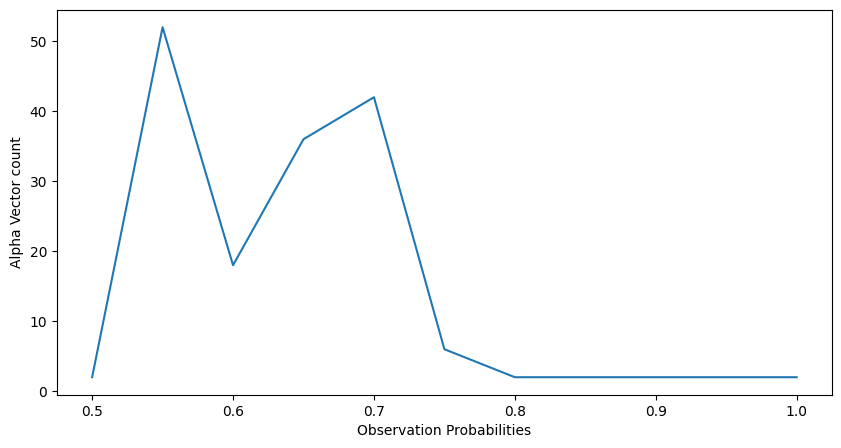

In [25]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0.5,1.0,11), [len(vf) for vf in value_functions])
plt.xlabel('Observation Probabilities')
plt.ylabel('Alpha Vector count')

In [26]:
value_functions[1]

<Figure size 700x500 with 0 Axes>

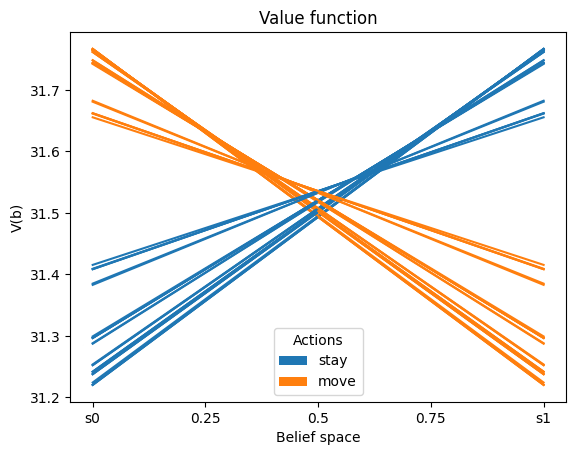

In [27]:
value_functions[1].plot()

In [25]:
for i, vf in enumerate(value_functions):
    print(f'Obs rate {obs_rnds[i]:.2f}: alpha count {len(vf)} (pruned {len(vf.prune(level=3))})')

Obs rate 0.50: alpha count 2 (pruned 2)
Obs rate 0.55: alpha count 52 (pruned 52)
Obs rate 0.60: alpha count 18 (pruned 18)
Obs rate 0.65: alpha count 36 (pruned 36)
Obs rate 0.70: alpha count 42 (pruned 42)
Obs rate 0.75: alpha count 6 (pruned 6)
Obs rate 0.80: alpha count 2 (pruned 2)
Obs rate 0.85: alpha count 2 (pruned 2)
Obs rate 0.90: alpha count 2 (pruned 2)
Obs rate 0.95: alpha count 2 (pruned 2)
Obs rate 1.00: alpha count 2 (pruned 2)


In [26]:
# sh = SolverHistory(
#     model,
#     value_functions[0],
#     all_beliefs,
#     expand_function='no_expand',
#     gamma=0.99,
#     eps=eps
#     )

# for vf in value_functions:
#     sh.add(vf, all_beliefs)

In [27]:
# sh.save_history_video(custom_name='obs_exp_observation', fps=1)

Video saved at 'Results/obs_exp_observation-s2-a2-no_expand-g0.99-e0.001-20230918_235907.mp4'...


An interesting thing about this second experiment was the confirmation that indeed, when observation probability is 100%, it converges to the same value function as for MDP Value Iteration given the same parameters (gamma, epsilon, transition,...).
Then, a second observation is the amount of alpha planes required to define the value function increases with the uncertainty of observation. This also makes sense in the way that the more the system is uncertain, the more nuance is needed to represent the value function along the belief space.